In [ ]:
!pip install -U tensorflow
!pip install tensorflow_decision_forests

Coding a supervised model to predict house prices based on their area, how many rooms and location

In [187]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

In [188]:
# Importing train dataset and taking a first look at it
dataset = pd.read_csv(r'train.csv')

# According to Kaggle, the column SalePrice is the target
dataset.shape

(1460, 81)

In [189]:
# Since there is a lot of columns, lets loop through it to see if there are Na values
lenght = len(dataset)
na_columns = []
for i in dataset.columns:
  x = dataset[i].count()
  if x != lenght:
    na_columns.append(i)

In [190]:
# Filling NA columns of dtype == object with a new class: Unknown and with the median in other cases
for column in na_columns:
  if dataset[column].dtype == 'object':
    dataset[column] = dataset[column].fillna('Unknown')

  elif dataset[column].dtype == 'float64':
    dataset[column] = dataset[column].fillna(dataset[column].median())

In [191]:
# Droping the ID column since it is not necessary
dataset.drop(['Id'], axis=1, inplace=True)

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


<Axes: xlabel='SalePrice', ylabel='Count'>

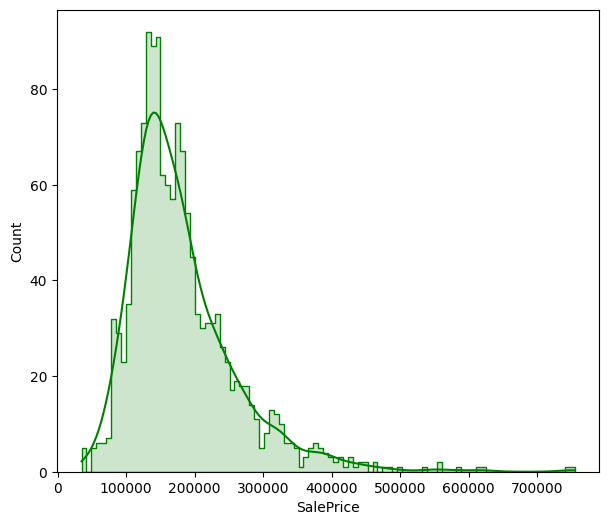

In [192]:
# Now let us take a look at how the house prices are distributed.
print(dataset['SalePrice'].describe())
plt.figure(figsize=(7, 6))
sns.histplot(data=dataset, x='SalePrice', color='g', bins=100, kde=True, element='step', alpha=0.2)

Preparing the dataset.

This dataset contains a mix of numeric, categorical and missing features (that we previously filled). TF-DF supports all these feature types natively, and no preprocessing is required. This is one advantage of tree-based models.

We need to convert the datatset from Pandas format (pd.DataFrame) into TensorFlow Datasets format (tf.data.Dataset). TensorFlow Datasets is a high performance data loading library which is helpful when training neural networks with accelerators like GPUs and TPUs.

By default the Random Forest Model is configured to train classification tasks. Since this is a regression problem, we will specify the type of the task (tfdf.keras.Task.REGRESSION) as a parameter here.

In [193]:
# Spliting the dataset into training and testing data
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset=dataset)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1159 examples in training, 301 examples in testing.


In [194]:
# Convert the dataset into a TensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label='SalePrice', task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label='SalePrice', task = tfdf.keras.Task.REGRESSION)

Now lets create an instance of our RandomForest and train it

In [195]:
# List of available models in TensorFlow
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [ ]:
# Creating instance and fitting model, specifying the task attribute
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"]) # Configure model to use the MSE as evaluating metric
rf.fit(train_ds)

Evaluate model on OOB (Out of bag) and validation dataset

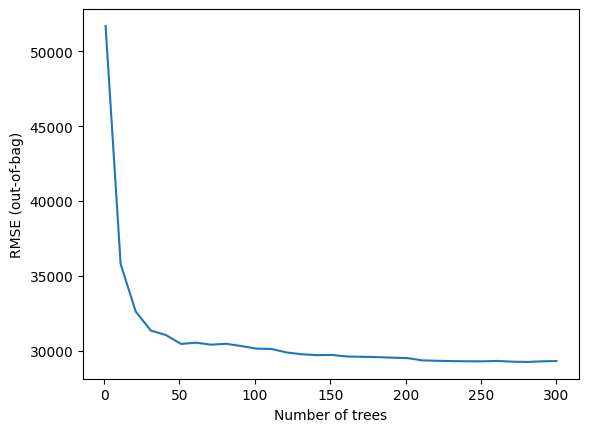

In [197]:
# Training logs of our model, including number of trees and evaluation metric on training step
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [198]:
# We can also see the general stats on the OOB dataset
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1159, accuracy=None, loss=None, rmse=29309.214156610455, ndcg=None, aucs=None, auuc=None, qini=None)

In [201]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 253ms/step - loss: 0.0000e+00 - mse: 637292672.0000
loss: 0.0000
mse: 637292672.0000


Now lets test out model on the test dataset

In [ ]:
# Importing test file
test_data = pd.read_csv(r'test.csv')

# Separating the Id column
ids = test_data.pop('Id')

# Transforming test data from Pandas DataFrame to TensorFlow dataset format
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, task = tfdf.keras.Task.REGRESSION)

# Predicting with our trained model
predict = rf.predict(test_ds)

# Creating a new pandas DataFrame using the poped Ids and Predicted Sales Values
prediction_df = pd.DataFrame({'Id': ids,
                              'Sale Price Prediction': predict.squeeze()})

prediction_df

2/2 [==============================] - 0s 16ms/step


,Id,Sale Price Prediction
0,1461,125024.281250
1,1462,153588.093750
2,1463,181215.531250
3,1464,185151.359375
4,1465,196394.171875
...,...,...
1454,2915,85820.359375
1455,2916,85347.804688
1456,2917,151905.031250
1457,2918,124304.976562
